# Custom LeNet Model

## This notebook has the following sections:

1. Prerequisites

2. Grid Search

3. Training using the Best Hyperparameters

4. Model Evaluation using a Confusion Matrix

5. Model Evaluation using K-Fold Cross Validation

# Section 1 - Prerequisites

In this section, we will import all the necessary libraries to run the notebook, define constants and invariants, and define the architecture of our model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Loading Datasets and Models
from keras.utils import image_dataset_from_directory
from keras.saving import load_model

# Saving Results
import os
import json

# Building our Model
from keras import Sequential
from keras.layers import Input, Rescaling, Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

# Compiling our Model
from keras.optimizers import SGD, Adam, RMSprop

# Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# K-Fold
from sklearn.model_selection import KFold

In [2]:
"""
Constants and Invariant Parameters
"""
# Invariant parameters
BATCH_SIZE = 16
EPOCHS = 10 # Due to limited hardware, we will only compute up to 10 epochs for realistic runtime constraints
VALIDATION_SPLIT = 0.2
SEED = 42

# Model tuning and evaluation
GRID_SEARCH_ITERATIONS = 3 # Number of attempts per hyperparameter combination (the score of these attempts will be averaged)
K_FOLDS = 5

# Constants
IMAGE_SIZE = (150, 150)
OPTIMIZERS = {
    "Adam": Adam,
    "SGD": SGD,
    "RMSprop": RMSprop,
}

# File and directory management
INPUT_DIRECTORY = "brain_tumor_dataset"
TESTING_DIRECTORY = "testing_dataset"
ORIGINAL_MODEL_NAME = "CustomLeNet"
MODEL_NAME = "CustomLeNetNoAugment"

In [3]:
"""
Define the model architecture
"""
def create_model(optimizer="SGD", learning_rate=0.001):
    model = Sequential([
        Input(shape=IMAGE_SIZE + tuple([3])), # (150, 150, 3)

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = OPTIMIZERS[optimizer]

    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [5]:
"""
Load the training dataset
"""
training_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)
validation_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)

Found 223 files belonging to 2 classes.
Using 179 files for training.
Found 223 files belonging to 2 classes.
Using 44 files for validation.


# Section 3 - Training using the Best Hyperparameters

In this section, we will train the model with the best hyperparameters, which were identified by the GridSearch results.

In [7]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(ORIGINAL_MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.0001)

In [10]:
"""
Create a model with the best-performing hyperparameters identified by the GridSearch results
"""

best_model = create_model(
    optimizer=best_optimizer,
    learning_rate=best_learning_rate,
)

history = best_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6487 - loss: 1.4546 - val_accuracy: 0.8182 - val_loss: 2.1140
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8180 - loss: 0.9598 - val_accuracy: 0.8409 - val_loss: 1.3646
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.8390 - loss: 0.6856 - val_accuracy: 0.7273 - val_loss: 1.0898
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8372 - loss: 0.6738 - val_accuracy: 0.8636 - val_loss: 0.8090
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9278 - loss: 0.4758 - val_accuracy: 0.8864 - val_loss: 0.7087
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9424 - loss: 0.4929 - val_accuracy: 0.8864 - val_loss: 0.6908
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9770 - loss: 0.3700 - val_accuracy: 0.7955 - val_loss: 0.7891
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9732 - loss: 0.3903 - val_accuracy: 0.

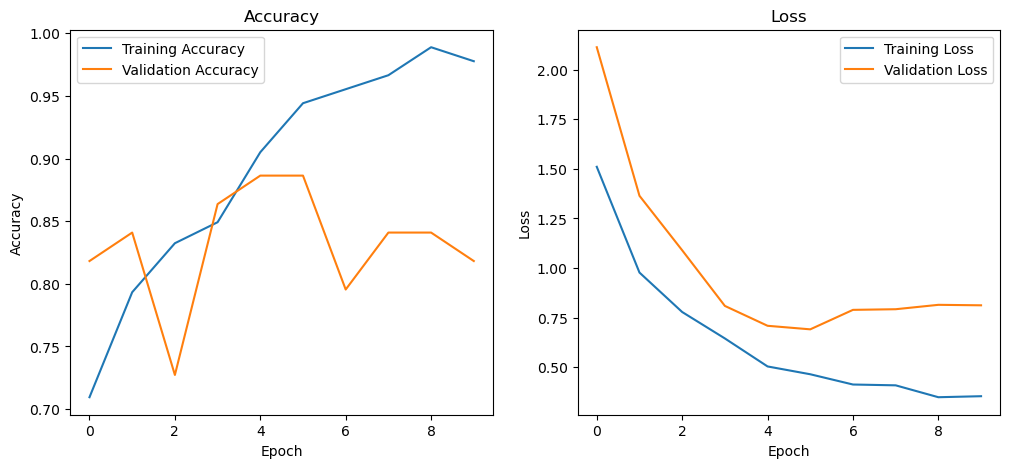

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8075 - loss: 0.7832
Test Accuracy: 0.82 Test Loss: 0.81


In [11]:
"""
Plot Accuracy & Loss for each Epoch
"""
plt.figure(figsize=(12, 5))

# Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"],     label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],     label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "history.png"))
plt.show()

# Show Overall Performance
test_loss, test_acc = best_model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f} Test Loss: {test_loss:.2f}")

In [12]:
"""
Save model and training history
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "history.json"), "w") as file:
    json.dump(history.history, file)

best_model.save(os.path.join(MODEL_NAME, "model.keras"))

# Section 4 - Model Evaluation using a Confusion Matrix

In this section, we will use the best model from the previous section to create a Confusion Matrix.

In [13]:
"""
Load the model trained using the best hyperparameters
"""
best_model = load_model(os.path.join(MODEL_NAME, "model.keras"))

In [15]:
"""
Predict each image in the test dataset
"""
testing_dataset = image_dataset_from_directory(
    TESTING_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

actual = []
predictions = []

for batch, labels in validation_dataset:
    results = best_model.predict(batch)  # Get raw predictions
    predicted_labels = (results > 0.5).astype(int).flatten()  # Convert probabilities to 0s and 1s
    predictions.extend(predicted_labels)  # Append predicted labels
    actual.extend(labels.numpy())  # Convert actual labels to list

print("Actual Labels:   ", actual)
print("Predicted Labels:", predictions)

Found 45 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual Labels:    [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Predicted Labels: [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]


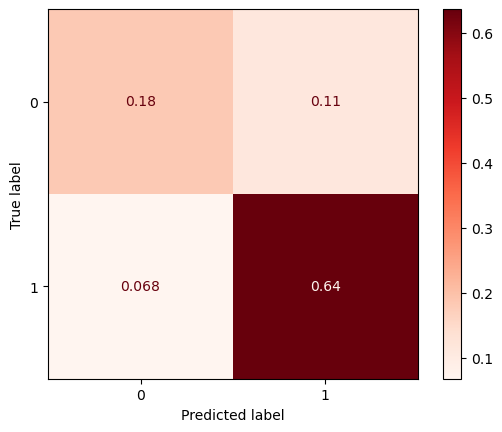

Accuracy: 0.8181818181818181


In [16]:
"""
Plot a Confusion Matrix of the test dataset predictions
"""
result = confusion_matrix(actual, predictions, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot(cmap="Reds")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "confusionmatrix.png"))
plt.show()

with open(os.path.join(MODEL_NAME, "confusionmatrix.json"), "w") as file:
    json.dump(result.tolist(), file)

print(f"Accuracy: {result[0][0] + result[1][1]}")